##  Laboratorio ETL + EDA

## Entorno y librerías



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

pd.set_option('display.max_columns', 200)
print('Librerías cargadas')

Librerías cargadas


## 1) ETL — Extracción



In [2]:
# Cargar el CSV correctamente
file_path = 'productos.csv'
df = pd.read_csv(file_path, sep='|', dtype=str)

print('Filas, columnas:', df.shape)
print('\nPrimeras filas:')
display(df.head())

print('\nColumnas:')
print(df.columns.tolist())

Filas, columnas: (11691, 17)

Primeras filas:


,id_comercio,id_bandera,id_sucursal,id_producto,productos_ean,productos_descripcion,productos_cantidad_presentacion,productos_unidad_medida_presentacion,productos_marca,productos_precio_lista,productos_precio_referencia,productos_cantidad_referencia,productos_unidad_medida_referencia,productos_precio_unitario_promo1,productos_leyenda_promo1,productos_precio_unitario_promo2,productos_leyenda_promo2
0,3,1,3,7791813434412,1,7UP FREE PET X 1.5L,1.00,unidad,,4550.00,4550.00,1,unidad,NaN,NaN,NaN,NaN
1,3,1,3,0000000023897,0,AFEITADORA BIC COMFORT 3,1.00,unidad,,820.00,820.00,1,unidad,NaN,NaN,NaN,NaN
2,3,1,3,7790580109882,1,AGUILA EXTRAFINO 60% CACAO X 150 GR,1.00,unidad,,12550.00,12550.00,1,unidad,NaN,NaN,NaN,NaN
3,3,1,3,7790040133594,1,AGUILA MINITORTA BROWNIE X 72G,1.00,unidad,,2050.00,2050.00,1,unidad,NaN,NaN,NaN,NaN
4,3,1,3,7790040298705,1,AGUILA MINITORTA DDLECHE/MOUSSE SAB.VAINILLA X...,1.00,unidad,,2050.00,2050.00,1,unidad,NaN,NaN,NaN,NaN



Columnas:
['id_comercio', 'id_bandera', 'id_sucursal', 'id_producto', 'productos_ean', 'productos_descripcion', 'productos_cantidad_presentacion', 'productos_unidad_medida_presentacion', 'productos_marca', 'productos_precio_lista', 'productos_precio_referencia', 'productos_cantidad_referencia', 'productos_unidad_medida_referencia', 'productos_precio_unitario_promo1', 'productos_leyenda_promo1', 'productos_precio_unitario_promo2', 'productos_leyenda_promo2']


### 1.1) Inspección inicial


In [3]:
# Inspección inicial
print('Valores nulos por columna:')
print(df.isnull().sum())
print('\nDuplicados totales:', df.duplicated().sum())

# Normalizar nombres de columnas
try:
    df.columns = df.columns.str.strip()
except Exception:
    pass
print('\nColumnas normalizadas:')
print(df.columns.tolist())

Valores nulos por columna:
id_comercio                                 0
id_bandera                                  1
id_sucursal                                 1
id_producto                                 1
productos_ean                               1
productos_descripcion                       1
productos_cantidad_presentacion             1
productos_unidad_medida_presentacion        1
productos_marca                             1
productos_precio_lista                      1
productos_precio_referencia                 1
productos_cantidad_referencia               1
productos_unidad_medida_referencia          1
productos_precio_unitario_promo1        11691
productos_leyenda_promo1                11691
productos_precio_unitario_promo2        11691
productos_leyenda_promo2                11691
dtype: int64

Duplicados totales: 0

Columnas normalizadas:
['id_comercio', 'id_bandera', 'id_sucursal', 'id_producto', 'productos_ean', 'productos_descripcion', 'productos_cantidad_presentac

### 1.2) Limpieza de columnas de precio y cantidades


In [4]:
# Identificar columnas que contienen 'precio' o 'cantidad' en el nombre
cols = df.columns.tolist()
price_cols = [c for c in cols if 'precio' in c.lower() or 'unitario' in c.lower()]
qty_cols = [c for c in cols if 'cantidad' in c.lower() or 'presentacion' in c.lower()]

print('Columnas detectadas como precio:', price_cols)
print('Columnas detectadas como cantidad:', qty_cols)

import re

def clean_price_series(s):
    s = s.astype(str).str.replace('\u00A0','', regex=False)
    s = s.str.replace(r'[^0-9,\.\-]', '', regex=True)
    def to_float(x):
        if x in ['', 'nan', 'None', 'NaN', None]:
            return np.nan
        x = x.replace(' ', '')
        if x.count('.')>0 and x.count(',')>0:
            x = x.replace('.','').replace(',','.')
        else:
            if x.count(',')>0 and x.count('.')==0:
                x = x.replace(',','.')
        try:
            return float(x)
        except:
            return np.nan
    return s.apply(to_float)

for c in price_cols:
    df[c+'_clean'] = clean_price_series(df[c])

for c in qty_cols:
    df[c+'_num'] = pd.to_numeric(df[c].str.replace(',','.'), errors='coerce')

print('\nPrimeras filas con columnas limpias:')
display(df.head()[[ *price_cols, *[c+'_clean' for c in price_cols], *qty_cols, *[c+'_num' for c in qty_cols] ]])

Columnas detectadas como precio: ['productos_precio_lista', 'productos_precio_referencia', 'productos_precio_unitario_promo1', 'productos_precio_unitario_promo2']
Columnas detectadas como cantidad: ['productos_cantidad_presentacion', 'productos_unidad_medida_presentacion', 'productos_cantidad_referencia']

Primeras filas con columnas limpias:


,productos_precio_lista,productos_precio_referencia,productos_precio_unitario_promo1,productos_precio_unitario_promo2,productos_precio_lista_clean,productos_precio_referencia_clean,productos_precio_unitario_promo1_clean,productos_precio_unitario_promo2_clean,productos_cantidad_presentacion,productos_unidad_medida_presentacion,productos_cantidad_referencia,productos_cantidad_presentacion_num,productos_unidad_medida_presentacion_num,productos_cantidad_referencia_num
0,4550.00,4550.00,NaN,NaN,4550.0,4550.0,NaN,NaN,1.00,unidad,1,1.0,NaN,1.0
1,820.00,820.00,NaN,NaN,820.0,820.0,NaN,NaN,1.00,unidad,1,1.0,NaN,1.0
2,12550.00,12550.00,NaN,NaN,12550.0,12550.0,NaN,NaN,1.00,unidad,1,1.0,NaN,1.0
3,2050.00,2050.00,NaN,NaN,2050.0,2050.0,NaN,NaN,1.00,unidad,1,1.0,NaN,1.0
4,2050.00,2050.00,NaN,NaN,2050.0,2050.0,NaN,NaN,1.00,unidad,1,1.0,NaN,1.0


### 1.3) Feature engineering


In [6]:
# Mapear columnas relevantes
col_map = {}
for c in df.columns:
    low = c.lower()
    if 'productos_precio_lista' in low or 'precio_lista' in low:
        col_map['precio_lista'] = c
    if 'productos_precio_unitario_promo1' in low or 'precio_unitario_promo1' in low:
        col_map['precio_unitario_promo1'] = c
    if 'productos_cantidad_presentacion' in low or 'cantidad_presentacion' in low:
        col_map['cantidad_presentacion'] = c

print('Mapeo detectado:', col_map)

# Identificar columnas limpias
precio_lista_clean = None
if 'precio_lista' in col_map:
    base = col_map['precio_lista']
    precio_lista_clean = base + '_clean' if base+'_clean' in df.columns else base
else:
    # Buscar la primera columna *_clean si no se detectó automáticamente
    for c in df.columns:
        if c.endswith('_clean'):
            precio_lista_clean = c
            break

promo1_clean = None
if 'precio_unitario_promo1' in col_map:
    p = col_map['precio_unitario_promo1']
    promo1_clean = p + '_clean' if p+'_clean' in df.columns else p

qty_col = None
if 'cantidad_presentacion' in col_map:
    qty_col = col_map['cantidad_presentacion']

# Crear df_clean con las columnas necesarias
df_clean = df.copy()

# Precio de lista
if precio_lista_clean:
    df_clean['precio_lista'] = df_clean[precio_lista_clean]
else:
    df_clean['precio_lista'] = np.nan

# Precio promocional
if promo1_clean:
    df_clean['precio_promo1'] = df_clean[promo1_clean]
else:
    df_clean['precio_promo1'] = np.nan

# Cantidad de presentación: convertimos a número con seguridad
if qty_col:
    if qty_col + '_num' in df.columns:
        df_clean['cantidad_presentacion'] = df_clean[qty_col + '_num']
    else:
        # Si no es numérica, convertimos texto con coma a número
        if df_clean[qty_col].dtype != 'object':
            df_clean['cantidad_presentacion'] = df_clean[qty_col]
        else:
            df_clean['cantidad_presentacion'] = pd.to_numeric(
                df_clean[qty_col].str.replace(',', '.'), errors='coerce'
            )
else:
    df_clean['cantidad_presentacion'] = np.nan

# Calcular precio por unidad
with np.errstate(divide='ignore', invalid='ignore'):
    df_clean['precio_por_unidad'] = df_clean['precio_lista'] / df_clean['cantidad_presentacion']

# Calcular descuento de la promo 1 (si existe)
if 'precio_promo1' in df_clean.columns:
    df_clean['descuento_pct_promo1'] = 100 * (1 - (df_clean['precio_promo1'] / df_clean['precio_lista']))

# Mostrar una muestra de las columnas finales
print('Columnas finales añadidas (muestra):')
display(df_clean[['productos_descripcion',
                  'productos_marca',
                  'precio_lista',
                  'precio_promo1',
                  'cantidad_presentacion',
                  'precio_por_unidad',
                  'descuento_pct_promo1']].head())


Mapeo detectado: {'cantidad_presentacion': 'productos_cantidad_presentacion_num', 'precio_lista': 'productos_precio_lista_clean', 'precio_unitario_promo1': 'productos_precio_unitario_promo1_clean'}
Columnas finales añadidas (muestra):


,productos_descripcion,productos_marca,precio_lista,precio_promo1,cantidad_presentacion,precio_por_unidad,descuento_pct_promo1
0,7UP FREE PET X 1.5L,,4550.0,NaN,1.0,4550.0,NaN
1,AFEITADORA BIC COMFORT 3,,820.0,NaN,1.0,820.0,NaN
2,AGUILA EXTRAFINO 60% CACAO X 150 GR,,12550.0,NaN,1.0,12550.0,NaN
3,AGUILA MINITORTA BROWNIE X 72G,,2050.0,NaN,1.0,2050.0,NaN
4,AGUILA MINITORTA DDLECHE/MOUSSE SAB.VAINILLA X...,,2050.0,NaN,1.0,2050.0,NaN


### 1.4) Guardar (opcional) — SQLite

In [7]:
engine = create_engine('sqlite:///productos_lab.db')
df_clean.to_sql('productos_clean', con=engine, if_exists='replace', index=False)
print('Guardado en productos_lab.db')

Guardado en productos_lab.db


## 2) EDA — Visualizaciones

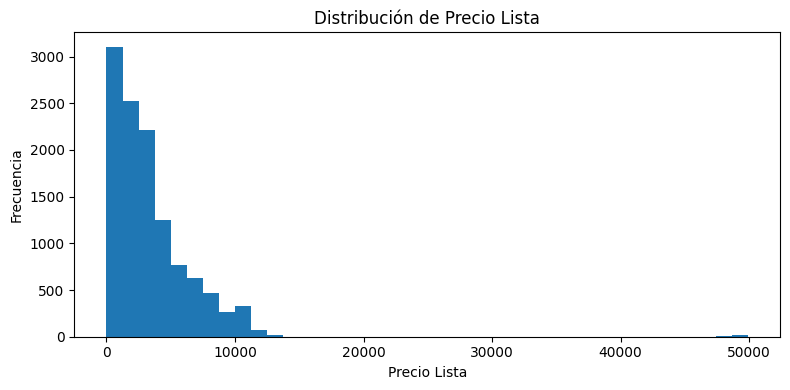

In [8]:
# Histograma de precio_lista
plt.figure(figsize=(8,4))
plt.hist(df_clean['precio_lista'].dropna(), bins=40)
plt.title('Distribución de Precio Lista')
plt.xlabel('Precio Lista')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

/tmp/ipython-input-3974820177.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=top_brands, showfliers=False)


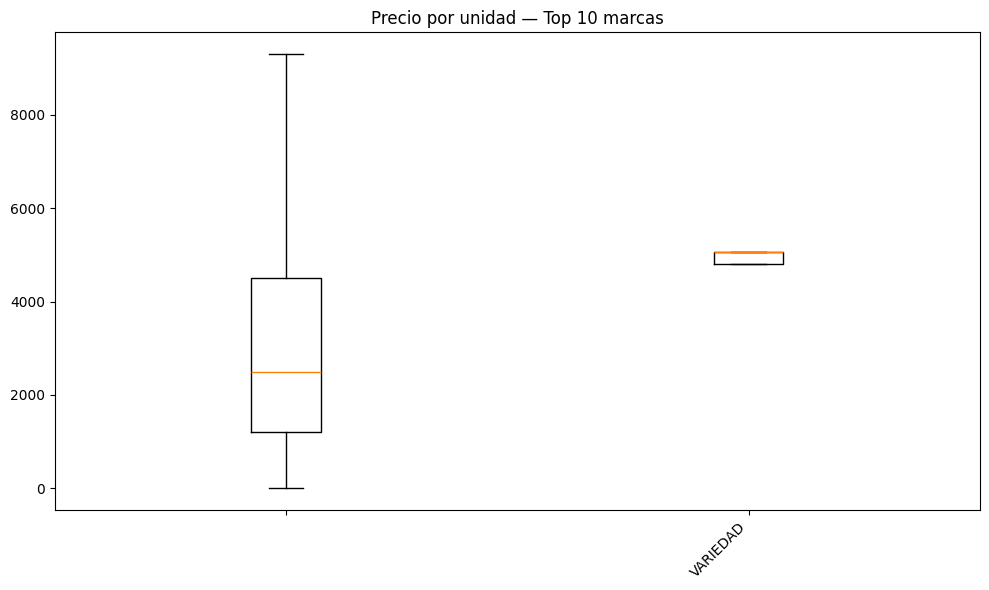

In [9]:
# Boxplot precio_por_unidad por top marcas
brand_col = 'productos_marca' if 'productos_marca' in df_clean.columns else df_clean.columns[0]
brand_counts = df_clean[brand_col].value_counts(dropna=True)
top_brands = brand_counts.head(10).index.tolist()
box_data = [df_clean.loc[df_clean[brand_col]==b, 'precio_por_unidad'].dropna() for b in top_brands]
plt.figure(figsize=(10,6))
plt.boxplot(box_data, labels=top_brands, showfliers=False)
plt.xticks(rotation=45, ha='right')
plt.title('Precio por unidad — Top 10 marcas')
plt.tight_layout()
plt.show()

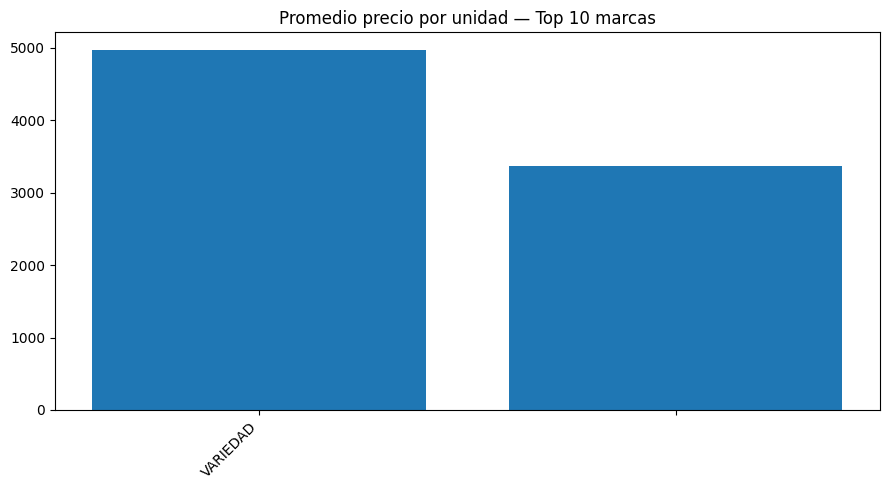

In [10]:
# Barra: promedio precio por unidad por marca (Top 10)
avg_by_brand = df_clean.groupby(brand_col)['precio_por_unidad'].mean().dropna().sort_values(ascending=False).head(10)
plt.figure(figsize=(9,5))
plt.bar(avg_by_brand.index, avg_by_brand.values)
plt.xticks(rotation=45, ha='right')
plt.title('Promedio precio por unidad — Top 10 marcas')
plt.tight_layout()
plt.show()

## 3) Preguntas de negocio

### Pregunta 1 — ¿Qué marcas tienen mayor precio promedio por unidad?

In [11]:
q1 = df_clean.groupby(brand_col)['precio_por_unidad'].agg(['mean','count']).reset_index().sort_values('mean', ascending=False)
display(q1.head(10))
print('\nInterpretación: estas marcas tienen mayor precio promedio por unidad; pueden indicar segmento premium.')

,productos_marca,mean,count
1,VARIEDAD,4966.666667,36
0,,3374.131793,11654



Interpretación: estas marcas tienen mayor precio promedio por unidad; pueden indicar segmento premium.


### Pregunta 2 — ¿Qué productos tienen mayores descuentos en promo1?

In [12]:
if 'descuento_pct_promo1' in df_clean.columns:
    q2 = df_clean[['productos_descripcion','productos_marca','precio_lista','precio_promo1','descuento_pct_promo1']].dropna(subset=['descuento_pct_promo1']).sort_values('descuento_pct_promo1', ascending=False).head(15)
    display(q2)
    print('\nInterpretación: promociones más agresivas detectadas.')
else:
    print('No hay datos de promo1 para esta pregunta.')

,productos_descripcion,productos_marca,precio_lista,precio_promo1,descuento_pct_promo1



Interpretación: promociones más agresivas detectadas.


### Pregunta 3 — ¿Cuáles son los productos con mayor precio por unidad?

In [13]:
q3 = df_clean[['productos_descripcion','productos_marca','precio_por_unidad']].dropna().sort_values('precio_por_unidad', ascending=False).head(20)
display(q3)
print('\nInterpretación: posibles productos premium o fuera de rango normal de precio.')

,productos_descripcion,productos_marca,precio_por_unidad
1376,COFLER BLOCK CHOCOLATE X 1KG,,49900.0
10794,COFLER BLOCK CHOCOLATE X 1KG,,49900.0
2676,COFLER BLOCK CHOCOLATE X 1KG,,49900.0
11118,COFLER BLOCK CHOCOLATE X 1KG,,49900.0
10470,COFLER BLOCK CHOCOLATE X 1KG,,49900.0
2351,COFLER BLOCK CHOCOLATE X 1KG,,49900.0
76,COFLER BLOCK CHOCOLATE X 1KG,,49900.0
1051,COFLER BLOCK CHOCOLATE X 1KG,,49900.0
9821,COFLER BLOCK CHOCOLATE X 1KG,,49900.0
5275,COFLER BLOCK CHOCOLATE X 1KG,,49900.0



Interpretación: posibles productos premium o fuera de rango normal de precio.
